In [1]:
%matplotlib inline


Treinando um classificador:


Sobre os dados
----------------

Em geral, quando você precisa lidar com dados de imagem, texto, áudio ou vídeo,
você pode usar pacotes python padrão que carregam dados em uma matriz numpy.
Então você pode converter esse array em uma Tensor.

- Para imagens, pacotes como Pillow, OpenCV são úteis
- Para áudio, pacotes como scipy 
- Para texto, carregamento bruto baseado em Python ou Cython ou NLTK e


Especificamente para a visão computacional, criamos um pacote chamado
 torchvision, que possui carregadores de dados para conjuntos de dados comuns, como Imagenet, CIFAR10, MNIST, etc. e transformadores de dados para imagens, a saber, `` torchvision.datasets`` e `` torch.utils.data.DataLoader``.

Isso oferece uma enorme conveniência e evita a gravação de código padrão.

Para este tutorial, usaremos o conjunto de dados CIFAR10.
Possui as classes: "avião", "automóvel", "pássaro", "gato", "cervo",
"Cachorro", "sapo", "cavalo", "navio", "caminhão". As imagens no CIFAR-10 são de
tamanho 3x32x32, ou seja, imagens em cores de 3 canais com tamanho de 32x32 pixels.


.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Treinando um classificador de imagens:
----------------------------

Realizaremos as seguintes etapas em ordem:

1. Carregue e normalize os conjuntos de dados de treinamento e teste do CIFAR10 usando
    `` visão da tocha``
2. Definir uma rede neural de convolução
3. Defina uma função de perda
4. Treine a rede nos dados de treinamento
5. Teste a rede nos dados de teste

1. Carregamento e normalização do CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Usando `` torchvision``, é extremamente fácil carregar o CIFAR10.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

A saída dos conjuntos de dados da visão da tocha são imagens PILImage do intervalo [0, 1]. Nós os transformamos em tensores de faixa normalizada [-1, 1].

In [35]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1, 0.2, 0.2), (0.6, 0.9, 0.1))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Vamos ver algumas imagens só por diversão

  car plane horse  bird


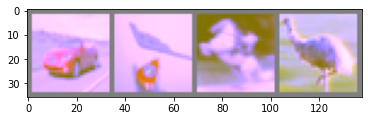

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Definir uma rede neural de convolução ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ 
Copie a rede neural antes e modifique-a para capturar imagens de 3 canais (em vez de imagens de 1 canal, conforme definido).



In [37]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x


net = Net()

3. Definir uma função de perda e otimizador ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ 


In [38]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.2)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

Aqui é quando os pesos começam a ser otimizados:



In [39]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.573
[1,  4000] loss: 1.833
[1,  6000] loss: 1.714


KeyboardInterrupt: ignored

5. Testando a rede em dados de teste:
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Treinamos a rede por 2 épocas. Temos que checar se ela aprendeu:



GroundTruth:   frog   car  frog  deer


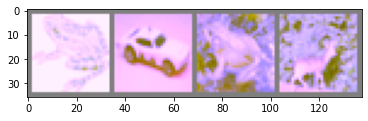

In [40]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


Ok, agora vamos ver o que a rede neural pensa que esses exemplos acima são:

In [41]:
outputs = net(images)

As saídas são energias para as 10 classes. Quanto maior a energia de uma classe, mais a rede pensa que a imagem é da classe específica. Então, vamos obter o índice da energia mais alta:

In [42]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat horse  bird  frog


Dupla: Lincoln Matheus Rodrigues de Almeida e Alex Fortes Pereira Matrículas: 201910757 e 201910445